# PUC MINAS

## Pós Graduação em Ciência de Dados e Big Data (2019-2020)

### Trabalho de Conclusão de Curso

### Aluna: Maria da Glória dos Santos Batista de Oliveira




__Leitura dos dados e importação das bibliotecas utilizadas__

Para iniciar o trabalho, primeiramente é necessário fazer download dos datasets informados previamente. Assim o documento poderá ser lido sem que qualquer problema ocorra.

No código a seguir, as importações das bibliotecas utilizadas e a definição dos métodos para facilitar a visualização dos dados e exibição de gráficos de value counts no Pandas.

In [1]:
import numpy as np
import pandas as pd

# Biblioteca usada para gráficos
from plotnine import *

# Biblioteca usada para dividir os dataframes entre: treinamento e teste
from sklearn.model_selection import TimeSeriesSplit

# Machine Learning
from fbprophet import Prophet 

# Não exibir as mensagens de warnings
import warnings
warnings.filterwarnings('ignore')

Vamos realizar as importações dos datasets utilizados:

In [2]:
# Import do dataset utilizado
mortos = '../datasets_tratados/df_mortos.csv'

# Filtrando as colunas que serão utilizadas:
lista_colunas = ["date", "count"]

df_mortos = pd.read_csv(mortos, sep=',', parse_dates=['date'], usecols=lista_colunas)

#### Visualizando os datasets:

In [3]:
# Visualizando o dataset
df_mortos.head(5)

,date,count
0,2020-02-25,0
1,2020-02-26,0
2,2020-02-27,0
3,2020-02-28,0
4,2020-02-29,0


#### - Formatação do dataframe

In [4]:
# Formatação realizada para que o dataframe seja usado depois:
df_mortos.columns = ['ds','y']
df_mortos['ds'] = pd.to_datetime(df_mortos['ds'])

In [5]:
# Inicializa a classe para separação
ts_split = TimeSeriesSplit(n_splits=5)

#### - Criando uma função que retornará os dataframes com a predição:

In [6]:
# Criando a função
def proc_gera_dados(df_mortos,ts_split,yearly_seasonality=True,weekly_seasonality=True,daily_seasonality=False):
    df_out=pd.DataFrame()
    for i,(train_i,test_i) in enumerate(ts_split.split(df_mortos)): #For Time Series Split
        # Utiliza os índices para pegar os dados corretos para separar
        df_train=df_mortos.copy().iloc[train_i,:]
        df_test=df_mortos.copy().iloc[test_i,:]
        # Construindo o modelo utilizandoo o Prophet para realizar predicões no dataframe de teste
        modelo=Prophet(
            yearly_seasonality=yearly_seasonality,
            weekly_seasonality=weekly_seasonality,
            daily_seasonality=daily_seasonality
        )
        modelo.fit(df_train)
        predictions=modelo.predict(df_test)

        #Combina predições e treinamento em um mesmo dataframe para gerar gráfico
        pred_df=predictions.loc[:,["ds","yhat"]]
        pred_df["y"]=df_test.y.tolist()
        df_train["train"]="Train"
        pred_df["train"]="Test"
        sub_df=df_train.append(pred_df).reset_index(drop=True)
        sub_df["split"]="Split "+str(i+1)
        sub_df["rmse"]=(np.mean((sub_df.yhat-sub_df.y)**2))**.5 # Calcula o RMSE para a separação
        df_out=df_out.append(sub_df).reset_index(drop=True)
    return df_out

INFO:numexpr.utils:NumExpr defaulting to 4 threads.
INFO:fbprophet:n_changepoints greater than number of observations. Using 24.


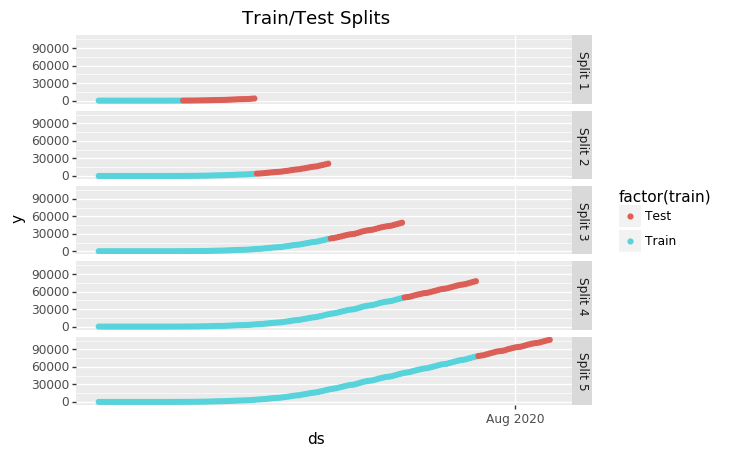

<ggplot: (8791887791577)>

In [7]:
# Gerando a predição dos modelos
df_sazonalidade_ano_semana = proc_gera_dados(
    df_mortos,ts_split,yearly_seasonality=True,weekly_seasonality=True)

(ggplot(df_sazonalidade_ano_semana,aes("ds","y",color="factor(train)"))+\
 geom_point()+facet_grid('split~.'))+\
labs(title="Train/Test Splits",x="ds",y="y")+\
scale_x_date(date_breaks="6 months",date_labels = "%b %Y")

#### - Visualizando a performance

In [8]:
# Criação dos dataframes
df_sazonalidade_nao=proc_gera_dados(df_mortos,ts_split,yearly_seasonality=False,weekly_seasonality=False)
df_sazonalidade_ano=proc_gera_dados(df_mortos,ts_split,weekly_seasonality=False)
df_sazonalidade_semanal=proc_gera_dados(df_mortos,ts_split,yearly_seasonality=False)

# Criando um dicionário a partir dos dataframes criados anteriormente
df_dict={"Ano-Semana":df_sazonalidade_ano_semana,"Nenhum":df_sazonalidade_nao,"Ano":df_sazonalidade_ano,"Semanal":df_sazonalidade_semanal}

INFO:fbprophet:n_changepoints greater than number of observations. Using 24.
INFO:fbprophet:n_changepoints greater than number of observations. Using 24.
INFO:fbprophet:n_changepoints greater than number of observations. Using 24.


In [9]:
# Gera o dataframe
cv_frame=pd.DataFrame()
for name,frame in df_dict.items():
    # Pega um único RMSE para cada separação
    values_lol=frame.groupby("split").agg({"rmse":"mean"}).values
    values=[item for sublist in values_lol for item in sublist] # Retorna a matriz 2D com sub-comprimento igual a 1
    sub_df=pd.DataFrame({"rmse":values})
    sub_df["modelo"]=name
    cv_frame=cv_frame.append(sub_df)

#### - Agora nos podemos criar um box plot para ver qual modelo performou melhor.

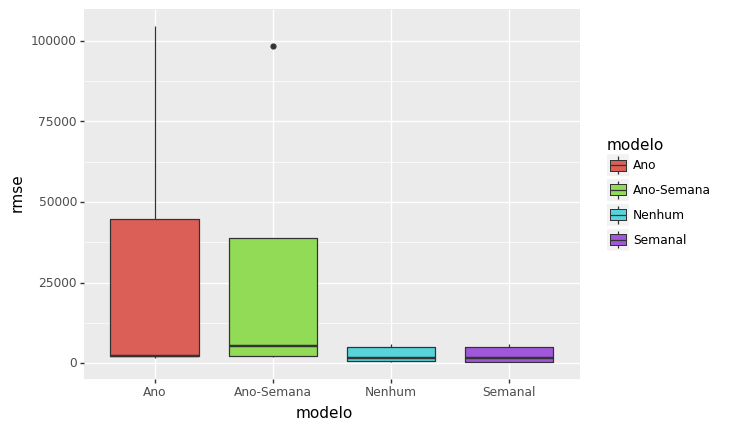

<ggplot: (8791888085273)>

In [10]:
# Gera o gráfico
(ggplot(cv_frame,aes(x="modelo",y="rmse",fill="modelo"))+geom_boxplot())

Dentre os modelos testados, o melhor modelo é o Semanal.